# HLCV Assignment 1
This notebook contains skeletons that you are supposed to fill in (watch out for <font color='red'>**TODO**</font> tags). In general, you are expected to implement methods yourself. For example, when asked to implement a method computing histograms you can use numpy array functions that help you implement this task, but not use the numpy implementation `np.histogram` for your solution. To submit your assignment, upload your completed notebook and a PDF report (use the provided Latex template with, for example, [Overleaf](http://overleaf.com)) that contains your observations.

In [15]:
import matplotlib.pyplot as plt, numpy as np, glob, os, scipy, itertools
# you do not need tqdm, but you might find it convenient
try:
    import tqdm.notebook as tqdm
except:
    class _tqdm:
        def tqdm(self, l):
            return l
    tqdm = _tqdm()

In this exercise you will first familiarise yourself with basic image filtering routines. The zip file contains image `graf.png`, which we will use for testing purposes.

# Part 1: Loading and Manipulating Images
We can load and show images using `matplotlib` for now.

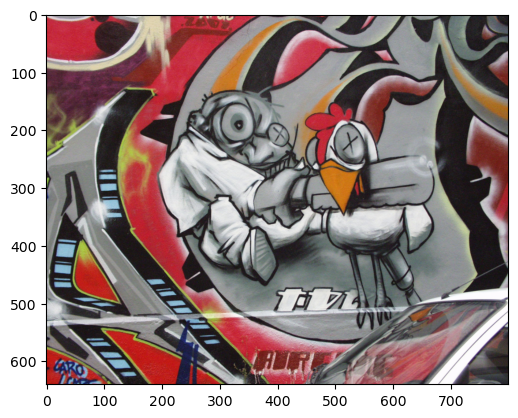

In [16]:
graf = plt.imread("graf.png")
plt.imshow(graf)

An image loaded with matplotlib is a matrix containing brightness values ∈ [0,1] for each color channel.

In [17]:
graf.shape
print(f'whole image pixels: {graf[0]}')
print(f'one pixel: {graf[0][0]}')
print(f'one color of one pixel: {graf[0,0,0]}')

whole image pixels: [[0.85882354 0.81960785 0.84313726]
 [0.84705883 0.80784315 0.84313726]
 [0.80784315 0.76862746 0.8117647 ]
 ...
 [0.07843138 0.11372549 0.10588235]
 [0.12156863 0.11372549 0.10980392]
 [0.11764706 0.06666667 0.07058824]]
one pixel: [0.85882354 0.81960785 0.84313726]
one color of one pixel: 0.8588235378265381


Usually, images are saved in RGB (3 color channels) and uint8 (1 byte = 256 brightness values). In any case, the loaded brightness values are initially discrete.

In [18]:
graf[0,0,0], graf[0,0,0]*255

(0.85882354, 219.0000021457672)

219

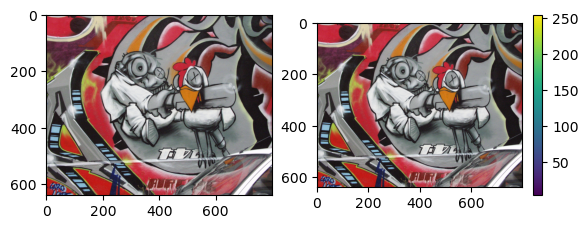

In [19]:
graf_uint8 = (graf*255).astype(np.uint8)

f, ax = plt.subplots(1,2)
ax[0].imshow(
    graf
)
i = ax[1].imshow(
    graf_uint8
)
plt.colorbar(i, fraction=0.04)
graf_uint8[0,0,0]

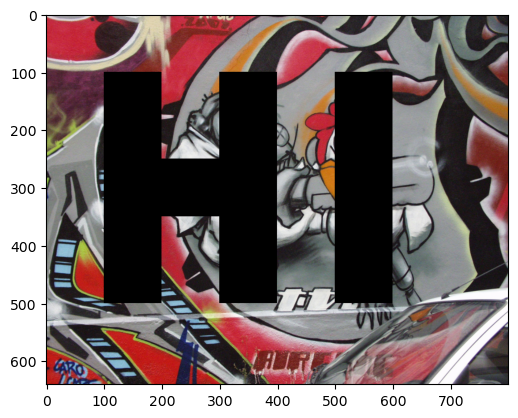

In [20]:
img = graf.copy()
img[100:500,100:200,:] = 0
img[250:350,200:300,:] = 0
img[100:500,300:400,:] = 0
img[100:500,500:600,:] = 0
plt.imshow(img)

<font color='red'>**TODO**</font>: Create 3 copies of the `graf` image where each only contains values in one color channel.

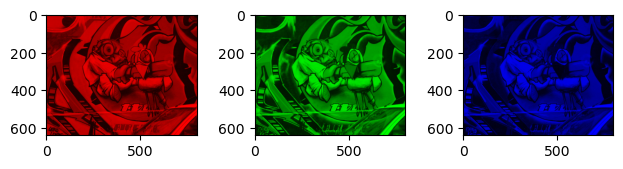

In [135]:
#RED GREEN BLUE
img = graf.copy()
# ... continue here
img_red = img.copy()
img_red[:,:,1:] = 0
img_green = img.copy()
img_green[:,:,0] = 0
img_green[:,:,2] = 0
img_blue = img.copy()
img_blue[:,:,0:2] = 0
f, ax = plt.subplots(1,3)
f.tight_layout()
ax[0].imshow(
    img_red
)
ax[1].imshow(
    img_green
)
ax[2].imshow(
    img_blue
)

<font color='red'>**TODO**</font>: Now lets turn the `graf` image into a gray value image by averaging over the color channels. Hint: `plt.imshow` has a default value for the argument `cmap` that you might want to change.

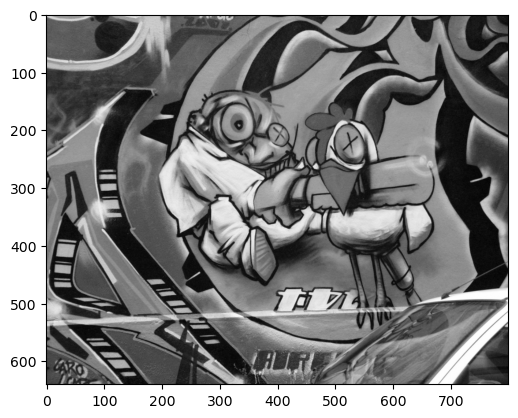

In [22]:
graf_gray = graf.copy()
# ... continue here
graf_gray = np.sum(graf_gray, axis=2)/3
plt.imshow(graf_gray, cmap="gray")

# Part 2: Image Filtering
## a) Gaussian Filter
<font color='red'>**TODO**</font>: Lets start with a simple 1D Gaussian. Implement a method which computes the values of a 1D Gaussian for a given variance σ². The method should also give a vector of values on which the Gaussian filter is defined: integer values on the interval [-3σ, 3σ].

$$
G = \frac{1}{\sqrt{2 \pi \sigma}} \exp\left(-\frac{x^2}{2\sigma^2}\right)
$$

In [136]:
def gauss(sigma):
    x = np.arange(-int(3*sigma), int(3*sigma)+1)
    print(x)
    # ... continue here
    y = (1/np.sqrt(2*np.pi*sigma))*np.exp(-(x**2/(2*sigma**2)))
    print(y)
    return x, y

[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12]
[0.00221592 0.00454678 0.00876415 0.01586983 0.02699548 0.04313866
 0.0647588  0.09132454 0.12098536 0.15056872 0.17603266 0.19333406
 0.19947114 0.19333406 0.17603266 0.15056872 0.12098536 0.09132454
 0.0647588  0.04313866 0.02699548 0.01586983 0.00876415 0.00454678
 0.00221592]


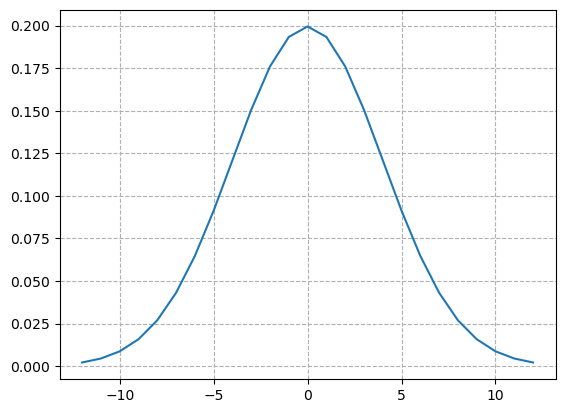

In [137]:
# plot your Gauss
sigma = 4.0
x, y = gauss(sigma)
plt.plot(x, y)
plt.grid(linestyle="--")

<font color='red'>**TODO**</font>: Implement a 2D Gaussian filter. The function should take an image as an input and return the result of convolution of this image with 2D Gaussian kernel. First, lets start by implementing the 2D Gaussian kernel. Complete function `gausskernel` below.

In [ ]:
def gausskernel(sigma):
    # ... continue here 
    # as per definition of the gaussian kernel the bigger sigma is the more spread it is
    # kernel size = 2 * spread + 1
    # using mgrid to make the center a 0 increase the values around it, 
    # so that after multiplication of x and y the center weight has the biggest 
    # value and the other values are mirroring

    # with double usage of 1d gauss:
    #
    # _, gaus1_out = gauss(sigma)
    # _, gaus2_out = gauss(sigma)
    # kernel = np.outer(gaus1_out, gaus2_out)
    # kernel /= np.sum(kernel)
    # 
    # with 2d gauss from internet
    
    spread = int(3 * sigma)
    x, y = np.mgrid[-spread:spread+1, -spread:spread+1]
    kernel = np.zeros((2*spread+1, 2*spread+1))
    kernel = (1/(2*np.pi*sigma**2))*np.exp(-(x**2 + y**2) / (2*sigma**2))
    return kernel

s=0.99795285391304
[[4.91032009e-06 1.94206927e-05 5.98199448e-05 1.43500588e-04
  2.68094393e-04 3.90075040e-04 4.42012928e-04 3.90075040e-04
  2.68094393e-04 1.43500588e-04 5.98199448e-05 1.94206927e-05
  4.91032009e-06]
 [1.94206927e-05 7.68103295e-05 2.36592471e-04 5.67555834e-04
  1.06033389e-03 1.54277671e-03 1.74819504e-03 1.54277671e-03
  1.06033389e-03 5.67555834e-04 2.36592471e-04 7.68103295e-05
  1.94206927e-05]
 [5.98199448e-05 2.36592471e-04 7.28756116e-04 1.74819504e-03
  3.26605832e-03 4.75208682e-03 5.38481983e-03 4.75208682e-03
  3.26605832e-03 1.74819504e-03 7.28756116e-04 2.36592471e-04
  5.98199448e-05]
 [1.43500588e-04 5.67555834e-04 1.74819504e-03 4.19370190e-03
  7.83486662e-03 1.13996637e-02 1.29175112e-02 1.13996637e-02
  7.83486662e-03 4.19370190e-03 1.74819504e-03 5.67555834e-04
  1.43500588e-04]
 [2.68094393e-04 1.06033389e-03 3.26605832e-03 7.83486662e-03
  1.46374579e-02 2.12973755e-02 2.41330882e-02 2.12973755e-02
  1.46374579e-02 7.83486662e-03 3.2660583

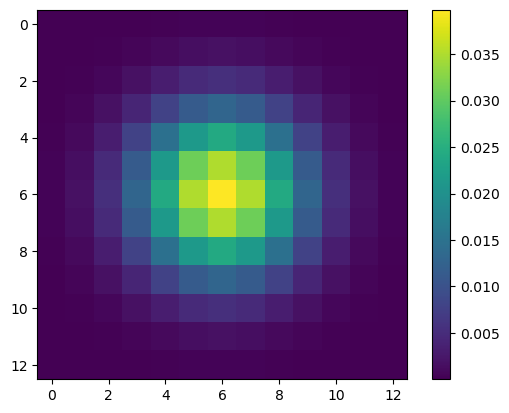

In [140]:
# plot your Gauss
kernel = gausskernel(2.0)
print(kernel)
print(kernel.shape)
plt.imshow(kernel)
plt.colorbar()

<font color='red'>**TODO**</font>: Now implement a convolution operation by completing function `my_convolution`. Afterwards you can test function `gaussfilter` - it should blur our example images.

In [27]:
def my_padding(image, padding=0):
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        return imagePadded
    
    return image

In [28]:
def my_convolution(image, kernel, padding=0, verbose=True):
    multiplications = 0
    # added for 2b 
    print("kernel shape", kernel.shape)
    # we flip the kernel since they are slided the other way around
    kernel = np.flipud(np.fliplr(kernel))
    xKernShape = kernel.shape[0] 
    yKernShape = kernel.shape[1] 
    xImgShape = image.shape[0] 
    yImgShape = image.shape[1]
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1) 
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))
    if verbose:
        print(output.shape)
    
    # Apply Equal Padding to All Sides
    imagePadded = my_padding(image, padding)
    
    # Iterate through image
    for y in range(yOutput):
        for x in range(xOutput):
            patch = imagePadded[x:x+xKernShape, y:y+yKernShape]
            output[x,y] = np.sum(patch * kernel)
            multiplications += xKernShape*yKernShape
    
    if verbose:
        print(f"Multiplications: {multiplications}")
    return output

def gaussfilter(image, sigma, padding=0):
    kernel = gausskernel(sigma)
    filtered = my_convolution(image, kernel, padding)
    return filtered

Here you can test your implementation. Start with `sigma=4.0` and play around with different sigma values.

kernel shape (25, 25)
(616, 776)
Multiplications: 298760000


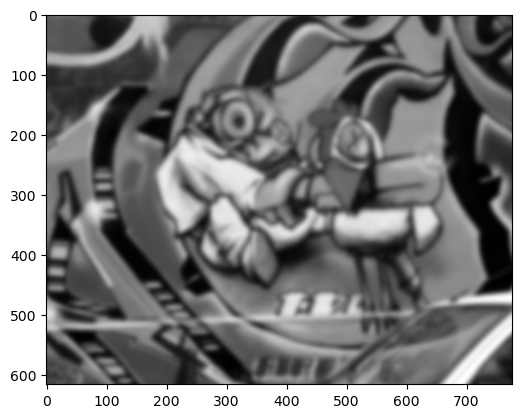

In [34]:
# higher sigma -> higher spread, more regional information -> more smoothing
graf_smooth = gaussfilter(graf_gray, sigma=4.0)

plt.imshow(graf_smooth, cmap="gray")
plt.show()

## b) Separability
The Gaussian filter is separable. This means we can first convolve each row of an image with a 1D filter and then convolve each column with another 1D filter instead of applying the corresponding 2D kernel (see lecture slides). Function `gaussfilter_sep` convolves a given image with two 1D Gaussians.

<font color='red'>**TODO**</font>: Test how much more efficient this method is compared to its 2D counterpart. What would you expect?

In [30]:
def gaussfilter_sep(image, sigma, padding=0):
    _, kernel = gauss(sigma)
    kernel = np.atleast_2d(kernel) / kernel.sum()
    # first the kernel is used and then its transpose
    filtered = my_convolution(image, kernel, padding)
    filtered = my_convolution(filtered, kernel.T, 0)
    return filtered

[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 7.53452359e-283
 8.73183128e-224 1.13878874e-171 1.67135722e-126 2.76047418e-088
 5.13081536e-057 1.07319187e-032 2.52613554e-015 6.69151129e-005
 1.99471140e-001 6.69151129e-005 2.52613554e-015 1.07319187e-032
 5.13081536e-057 2.76047418e-088 1.67135722e-126 1.13878874e-171
 8.73183128e-224 7.53452359e-283 0.00000000e+000 0.00000000e+000
 0.00000000e+000]
kernel shape (1, 25)
(640, 776)
Multiplications: 12416000
kernel shape (25, 1)
(616, 776)
Multiplications: 11950400


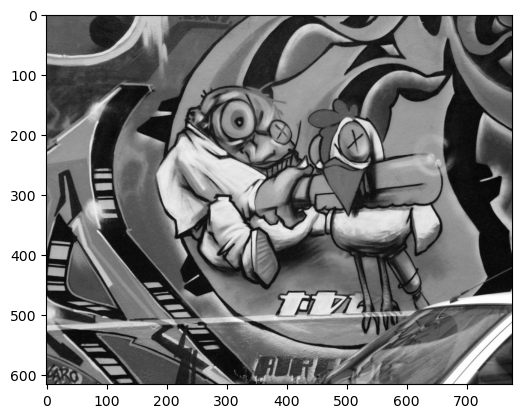

Diff. graf_smooth vs. graf_smooth_sep: 30844.297534495


In [82]:
graf_smooth_sep = gaussfilter_sep(graf_gray, sigma=4.0, padding=0)
plt.imshow(graf_smooth_sep, cmap="gray")
plt.show()

print(f"Diff. graf_smooth vs. graf_smooth_sep: {abs(graf_smooth-graf_smooth_sep).sum()}")

## c) Derivative Filter
<font color='red'>**TODO**</font>: Implement a function `gaussdx` for creating a Gaussian derivative filter in 1D according to the following equation:

$$
\frac{d}{dx} G 
= \frac{d}{dx} \frac{1}{\sqrt{2 \pi \sigma}} \exp\left(-\frac{x^2}{2\sigma^2}\right) \\
= -\frac{1}{\sqrt{2 \pi \sigma^3}} x \exp\left(-\frac{x^2}{2\sigma^2}\right)
$$

In [156]:
def gaussdx(sigma):
    x = np.arange(-int(3*sigma), int(3*sigma)+1)
    y = -(x * np.exp(-((x**2) / (2*sigma**2))) / np.sqrt(2*np.pi*sigma**3))
    return x, y

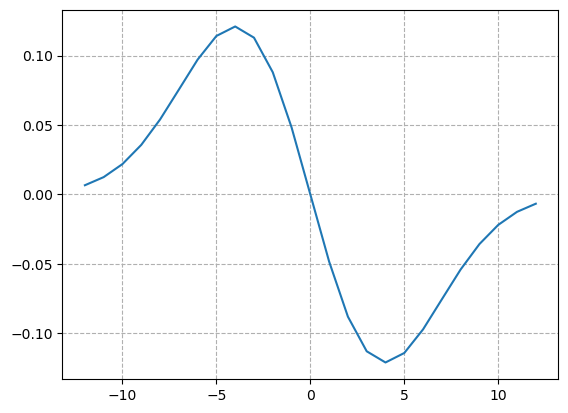

In [157]:
# plot your derivative filter
sigma = 4.0
x, y = gaussdx(sigma)
plt.plot(x, y)
plt.grid(linestyle="--")

The effect of applying a filter can be studied by observing its so-called impulse response. For this, we create a test image in which only the central pixel has a non-zero value:

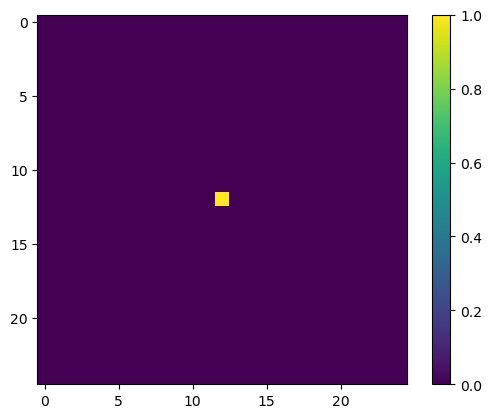

In [85]:
test_img = np.zeros((25,25))
test_img[12,12] = 1
plt.imshow(test_img)
plt.colorbar()

Now, given the following **1D** filter kernels:

In [86]:
_, G = gauss(1)
G = np.atleast_2d(G).T
_, D = gaussdx(1)
D = np.atleast_2d(D).T

[-3 -2 -1  0  1  2  3]
[0.00443185 0.05399097 0.24197072 0.39894228 0.24197072 0.05399097
 0.00443185]


<font color='red'>**TODO**</font>: What happens when you apply the following filter combinations? (G' is the transpose of G)
1. first G, then G'
2. first G, then D'
3. first D, then G'
4. first G', then D
5. first D', then G

First visualize each result on the test image. Then, answer the following question: What is the expected result when applying these filters to images?

kernel shape (7, 1)
(19, 25)
Multiplications: 3325
kernel shape (1, 7)
(19, 19)
Multiplications: 2527
kernel shape (7, 1)
(19, 25)
Multiplications: 3325
kernel shape (1, 7)
(19, 19)
Multiplications: 2527
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0

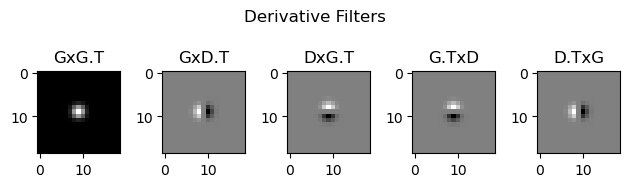

In [106]:
# ... continue here
# test_img
def combine_1Ds(image, first_kernel, second_kernel, padding=0):
    first_application = my_convolution(image, first_kernel, padding)
    second_aplication = my_convolution(first_application, second_kernel, padding)
    return second_aplication

'''
combination of G and D.T returns the derivative of the vertical lines
combination of D and G.T returns the derivative of the horizontal lines
'''
fig, (axs, axs2, axs3, axs4, axs5) = plt.subplots(1, 5)
axs.imshow(combine_1Ds(test_img, G, G.T, padding=0), cmap="gray")
axs.set_title("GxG.T")

axs2.imshow(combine_1Ds(test_img, G, D.T, padding=0), cmap="gray")
axs2.set_title("GxD.T")

axs3.imshow(combine_1Ds(test_img, D, G.T, padding=0), cmap="gray")
axs3.set_title("DxG.T")

axs4.imshow(combine_1Ds(test_img, G.T, D, padding=0), cmap="gray")
axs4.set_title("G.TxD")

axs5.imshow(combine_1Ds(test_img, D.T, G, padding=0), cmap="gray")
axs5.set_title("D.TxG")

fig.tight_layout()
fig.suptitle("Derivative Filters")
fig.subplots_adjust(top=1.5)
plt.show()

<font color='red'>**TODO**</font>: Use functions `gauss` and `gaussdx` in order to implement a function `gaussderiv` that returns the 2D Gaussian derivatives of an input image in x and y direction. Try the function on the given example images and comment on the output.

In [160]:
def gaussderiv(image, sigma, verbose=True):
    # ... continue here
    _, G = gauss(sigma)
    _, D = gaussdx(sigma)
    # kernel: change along the x axis -> derivative of x -> captures vertical lines
    # kernel.T: change along the y axis -> derivative of y -> captures horizontal lines
    kernel = np.outer(G, D)
    # assuming normalization is needed since gauss and gaussdx are normalized
    kernel /= kernel.sum()
    
    output1 = my_convolution(image, kernel, 0, verbose=verbose)
    output2 = my_convolution(image, kernel.T, 0, verbose=verbose)
    return kernel, output1, output2

[-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[0.00313379 0.01239438 0.03817738 0.09158277 0.17109914 0.24894778
 0.28209479 0.24894778 0.17109914 0.09158277 0.03817738 0.01239438
 0.00313379]
kernel shape (13, 13)
(628, 788)
Multiplications: 83632016
kernel shape (13, 13)
(628, 788)
Multiplications: 83632016


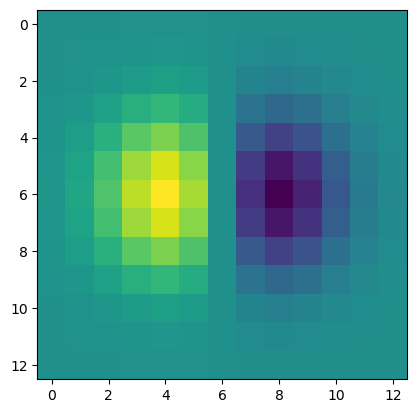

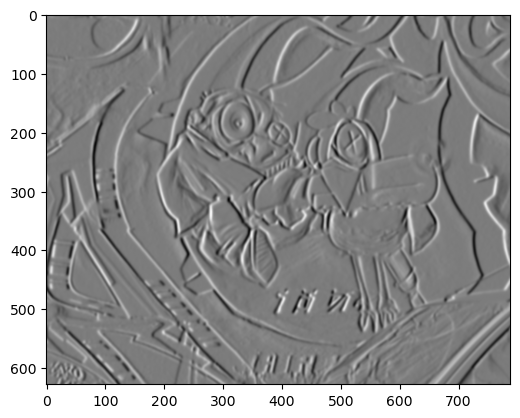

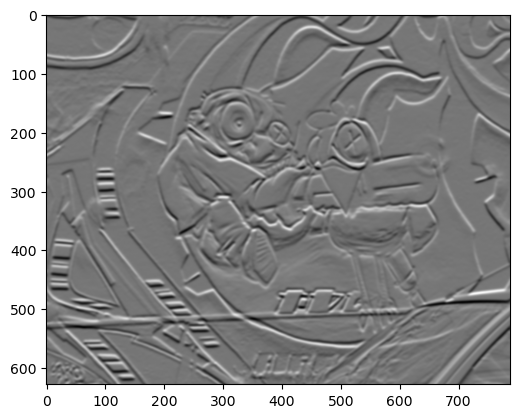

In [161]:
kernel, dx, dy = gaussderiv(graf_gray, sigma=2.0)

plt.imshow(kernel)
plt.show()
plt.imshow(dx, cmap="gray")
plt.show()
plt.imshow(dy, cmap="gray")
plt.show()

# Part 3: Object Identification
In this part you will develop a simple image querying system which accepts a query image as input and then finds a set of similar images in the database. In order to compare images you will implement several distance functions introduced in the lecture and evaluate their performance in combination with different image representations. The data contains model and query images, which will be used to evaluate your implementation. The model and query images correspond to the same set of objects photographed from different viewpoints.
## Loading Images
The following cell loads all model and query images into numpy arrays. Make sure the *model* and *query* folders are in the same folder as this notebook's file.

In [131]:
files_model = []
images_model = []
files_query = []
images_query = []

files = [f"obj{i}__0.png" for i in range(1,101)]

for f in files:
    f = os.path.join(".", "model", f)
    if os.path.isfile(f):
        name = os.path.basename(f).replace("__0.png","")
        files_model += [name]
        images_model += [plt.imread(f)]
        file_query = f"{name}__40.png"
        files_query += [file_query]
        images_query += [plt.imread(os.path.join(".", "query", file_query))]

# stack and convert to grayscale
images_model = np.stack(images_model)
images_model_gray = 0.2989 * images_model[:,:,:,0] + \
                    0.5870 * images_model[:,:,:,1] + \
                    0.1140 * images_model[:,:,:,2]
images_query = np.stack(images_query)
images_query_gray = 0.2989 * images_query[:,:,:,0] + \
                    0.5870 * images_query[:,:,:,1] + \
                    0.1140 * images_query[:,:,:,2]

files_model = np.array(files_model)
files_query = np.array(files_query)

print(images_model.shape, images_model_gray.shape)

(89, 128, 128, 3) (89, 128, 128)


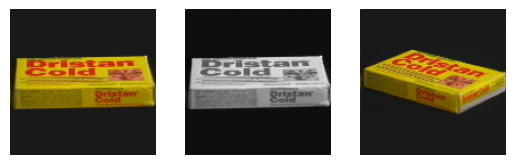

In [132]:
f, ax = plt.subplots(1,3)
ax[0].imshow(images_model[0])
ax[1].imshow(images_model_gray[0], cmap="gray")
ax[2].imshow(images_query[0])
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
plt.show()

## a) Image Representations, Histogram Distances

### Intensity Histogram

Implement function `normalized_hist`, which takes a gray-value image as input and returns the normalized histogram of pixel intensities. Compare results of your implementation with numpy’s `np.histogram` function to check if your implementation works as intended.

<font color='red'>**TODO:**</font> Complete the next cell to compute a normalized histogram of pixel intensities. Do **not** use existing implementations, e.g. `numpy.histogram`, to do so. [Read up about histograms if necessary](https://en.wikipedia.org/wiki/Histogram).

In [171]:
def normalized_hist(image, nbins=10):
    h = np.zeros(nbins)
    # ... continue here
    for i in image:
        for j in i:
            h[int(j*nbins)] += 1

    h = h / h.sum()
    return h

Compare your result with numpy's implementation.

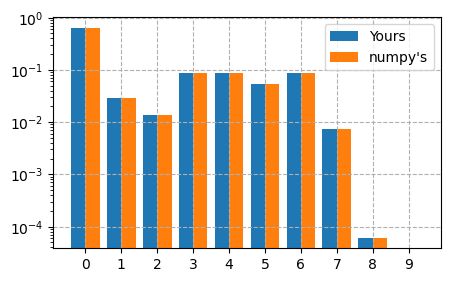

In [172]:
nbins = 10
image_id = 0

h1 = normalized_hist(images_model_gray[image_id], nbins=nbins)
h2, _ = np.histogram(images_model_gray[image_id], bins=np.linspace(0,1,nbins+1))
h2 = h2 / h2.sum()

f = plt.figure(figsize=(5,3))
plt.bar(np.arange(nbins)-0.2, h1, width=0.4)
plt.bar(np.arange(nbins)+0.2, h2, width=0.4)
plt.yscale("log")
plt.xticks(range(nbins))
plt.grid(linestyle="--")
plt.legend(["Yours", "numpy's"])
plt.show()

### RGB Histogram
<font color='red'>**TODO:**</font> Implement the 3-dimensional, normalized RGB-histogram by completing function `rgb_hist`. Go back to the lecture slides for reference.

In [281]:
def rgb_hist(image, nbins=10):
    h = np.zeros((nbins,nbins,nbins))
    # ... continue here
    for i in image:
        for j in i:
            # as in the lecture, color normalized based on intesnity
            intensity = j[0]+ j[1] + j[2]
            if(int(j[0]*nbins/intensity) == nbins or int(j[1]*nbins/intensity) == nbins or int(j[2]*nbins/intensity) == nbins):
                h[int(j[0]*nbins/intensity - 1e-9),int(j[1]*nbins/intensity - 1e-9),int(j[2]*nbins/intensity - 1e-9)] += 1
            else:
                h[int(j[0]*nbins/intensity),int(j[1]*nbins/intensity),int(j[2]*nbins/intensity)] += 1
    h = h / h.sum()
    return h

Plot your result.

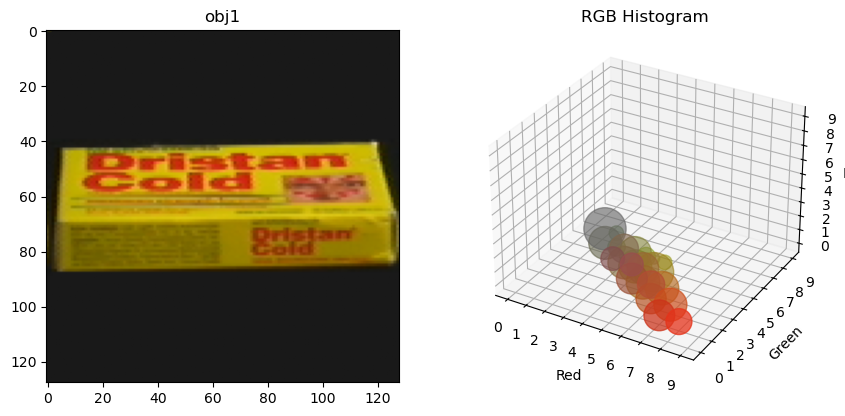

In [185]:
nbins = 10
image_id = 0

h1 = rgb_hist(images_model[image_id], nbins=nbins)

# lets scale and convert our histogram numbers to log-scale to improve visibility
with np.errstate(divide='ignore'):
    h1 = h1 / min(h1[h1!=0])
    h1 = np.nan_to_num(np.log(h1), neginf=0)*100

idx = np.indices((nbins,nbins,nbins)).reshape(3,-1)

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(1,2,1)
ax.imshow(images_model[image_id])
ax.set_title(files_model[image_id])

ax = f.add_subplot(1,2,2, projection="3d")
ax.scatter3D(
    idx[0], idx[1], idx[2],
    c = [( (idx[0,i]+1)/nbins, (idx[1,i]+1)/nbins, (idx[2,i]+1)/nbins ) for i in range(nbins**3)],
    s = [h1[idx[0,i],idx[1,i],idx[2,i]] for i in range(nbins**3)]
)
ax.set_xticks(range(nbins))
ax.set_yticks(range(nbins))
ax.set_zticks(range(nbins))
ax.set_title("RGB Histogram")
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
plt.show()

### RG Histogram
<font color='red'>**TODO:**</font> Complete function `rg_hist` to compute a normalized 2-dimensional chromatic representation RG-histogram (see lecture slides).

In [344]:
def rg_hist(image, nbins=10):
    h = np.zeros((nbins,nbins))
    for i in image:
        for j in i:
            intensity = j[0]+ j[1] + j[2]
            if j[0]*nbins/intensity == nbins or j[1]*nbins/intensity == nbins:
                h[int(j[0]*nbins/intensity - 1e-9),int(j[1]*nbins/intensity - 1e-9)] += 1
            else:
                h[int(j[0]*nbins/intensity),int(j[1]*nbins/intensity)] += 1
            
    h /= h.sum()
    return h

Plot your result.

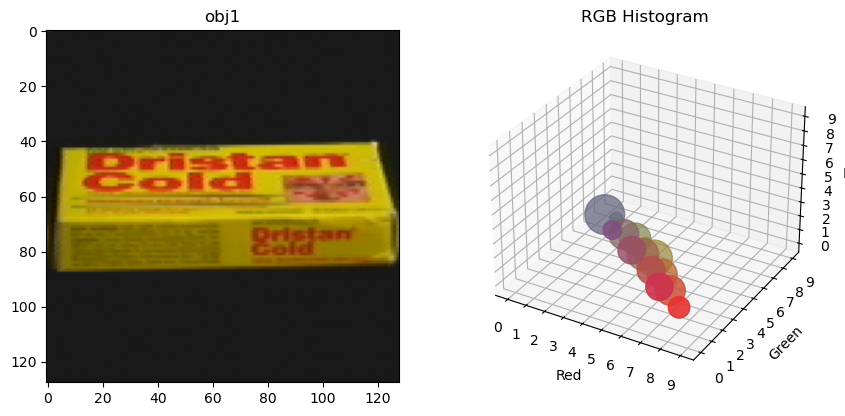

In [190]:
nbins = 10
image_id = 0
h1 = rg_hist(images_model[image_id], nbins=nbins)

# lets scale and convert our histogram numbers to log-scale to improve visibility
with np.errstate(divide='ignore'):
    h1 = h1 / min(h1[h1!=0])
    h1 = np.nan_to_num(np.log(h1), neginf=0)*100

idx = np.array([(r,g,b) for r,g,b in np.indices((nbins,nbins,nbins)).reshape(3,-1).T if r+g+b == nbins]).T

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(1,2,1)
ax.imshow(images_model[image_id])
ax.set_title(files_model[image_id])

ax = f.add_subplot(1,2,2, projection="3d")
ax.scatter3D(
    idx[0], idx[1], idx[2],
    c = [( (idx[0,i]+1)/nbins, (idx[1,i]+1)/nbins, (idx[2,i]+1)/nbins ) for i in range(idx.shape[1])],
    s = [h1[idx[0,i],idx[1,i]] for i in range(idx.shape[1])]
)
ax.set_xticks(range(nbins))
ax.set_yticks(range(nbins))
ax.set_zticks(range(nbins))
ax.set_title("RGB Histogram")
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
plt.show()

### dxdy Histogram
<font color='red'>**TODO:**</font> The dxdy histogram computes the 2D histogram of partial derivatives in x and y directions. Implement this histogram by completing function `dxdy_hist`. Hint: Scale the values to [0,1] before computing the histogram.

In [298]:
def dxdy_hist(image, nbins=10):
    h = np.zeros((nbins,nbins))
    _, dx, dy = gaussderiv(image, sigma=1, verbose=False)
    # ... continue here
    

    dx = (dx - dx.min()) / (dx.max() - dx.min())
    dy = (dy - dy.min()) / (dy.max() - dy.min())
    #print(dx.shape, dy.shape)

    for i, k in zip(dx, dy):
        for j, l in zip(i, k):
            # -1e-9 is to avoid the maximum value of 1.0 and by thus an out of index bounds error
            if(j*nbins == nbins or l*nbins == nbins):
                h[int(j*nbins - 1e-9),int(l*nbins - 1e-9)] += 1
            else:
                h[int(j*nbins),int(l*nbins)] += 1
            
    h /= h.sum()
    # h[0] /= h[0].sum()
    # h[1] /= h[1].sum()
    return h

Plot your result.

[-3 -2 -1  0  1  2  3]
[0.00443185 0.05399097 0.24197072 0.39894228 0.24197072 0.05399097
 0.00443185]
kernel shape (7, 7)
kernel shape (7, 7)
[[0.53778299 0.53788888 0.53790174 ... 0.53790174 0.53790174 0.53790174]
 [0.53790174 0.53790174 0.53790174 ... 0.53790174 0.53790174 0.53790174]
 [0.53790174 0.53790174 0.53790174 ... 0.53790174 0.53790174 0.53790174]
 ...
 [0.53790174 0.53790174 0.53790174 ... 0.53790174 0.53790174 0.53790174]
 [0.53790174 0.53790174 0.53790174 ... 0.53790174 0.53790174 0.53790174]
 [0.53790174 0.53790174 0.53790174 ... 0.53790174 0.53790174 0.53790174]]


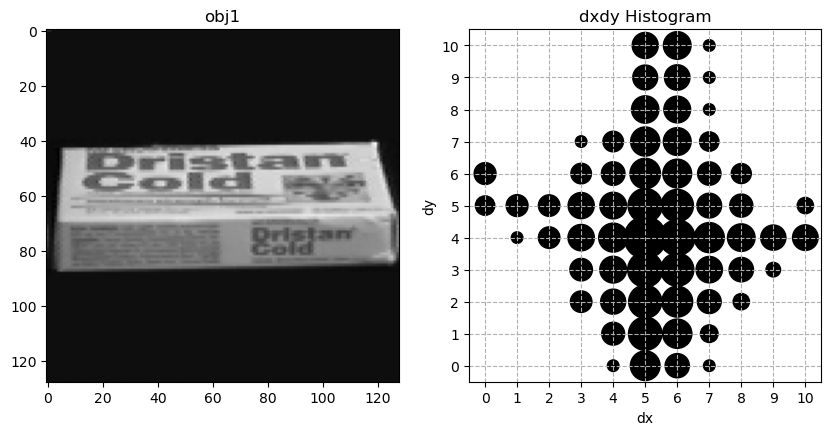

In [233]:
nbins = 11
image_id = 0
h1 = dxdy_hist(images_model_gray[image_id], nbins=nbins)

# lets scale and convert our histogram numbers to log-scale to improve visibility
with np.errstate(divide='ignore'):
    h1 = h1 / min(h1[h1!=0])
    h1 = np.nan_to_num(np.log(h1), neginf=0)*100

idx = np.indices((nbins,nbins)).reshape(2,-1)

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(1,2,1)
ax.imshow(images_model_gray[image_id], cmap="gray")
ax.set_title(files_model[image_id])

ax = f.add_subplot(1,2,2)
ax.scatter(
    idx[0], idx[1],
    c = "black",
    s = [h1[idx[0,i],idx[1,i]] for i in range(idx.shape[1])]
)
ax.set_xticks(range(nbins))
ax.set_yticks(range(nbins))
ax.set_title("dxdy Histogram")
ax.set_xlabel("dx")
ax.set_ylabel("dy")
ax.set_aspect("equal")
ax.grid(linestyle="--")
plt.show()

## b) Histogram Comparison Measures
Implement the histogram distance functions discussed during the lecture by filling the missing code in functions `dist_l2`, `dist_intersect`, and `dist_chi2`.
### Euclidean Distance
<font color='red'>**TODO:**</font> Implement the euclidean distance function to compare two histograms *x* and *y*.

In [238]:
def dist_l2(x,y):
    # ... continue here
    d = ((x - y)**2).sum()
    return d

Test your implementation:

In [239]:
a = np.array([1,2,3,4]) / 10
b = np.array([1,2,4,7]) / 15
dist_l2(a,b) == 0.01111111111111111

True

### Intersection
<font color='red'>**TODO:**</font> Implement the intersection distance function to compare two histograms *x* and *y*.

In [353]:
def dist_intersect(x,y):
    # compute intersection distance between x and y
    # return 1 - intersection, so that smaller values also correspond to more similar histograms
    x = x.flatten()
    y = y.flatten()
    a = np.zeros(len(x))
    for i in range(len(x)):
        a[i] = x[i] if x[i] < y[i] else y[i]
    intersection = a.sum()
    return 1-intersection

Test your implementation:

In [273]:
a = np.array([1,2,3,4]) / 10
b = np.array([1,2,4,7]) / 15
dist_intersect(a,b) == 0.1333333333333333

[0.1 0.2 0.3 0.4]
[0. 0. 0. 0.]


True

### Chi-Square
<font color='red'>**TODO:**</font> Implement the chi-square distance function to compare two histograms *x* and *y*. Note: Add a small value (1E-6) to the denominator to avoid division by zero.

In [246]:
def dist_chi2(x,y):
    # compute chi2 distance between x and y
    # add small value to denominator to not divide by zero
    d = (((x-y)**2)/(x + y + 1e-6)).sum()
    return d

Test your implementation:

In [247]:
a = np.array([1,2,3,4]) / 10
b = np.array([1,2,4,7]) / 15
dist_chi2(a,b) == 0.027088900064936177

True

## c) Object Identification
Having implemented different distance functions and image histograms, we can now test how suitable they are for retrieving images in a query-by-example scenario. Function `find_best_match` takes a list of model images and a list of query images and for each query image returns the index of closest model image according to the given histogram function, distance function, and number of bins. Additionally to the indices of the best matching images, the function returns a matrix which contains distances between all pairs of model and query images.

In [372]:
def find_best_match(model_ids, query_ids, f_hist, f_dist, bins):
    distances = np.zeros((len(query_ids), len(model_ids)))
    
    m_histograms = []
    for idx in model_ids:
        img = images_model[idx] if f_hist in [rgb_hist, rg_hist] else images_model_gray[idx]
        m_histograms += [f_hist(img, bins)]
    
    q_histograms = []
    for idx in query_ids:
        img = images_query[idx] if f_hist in [rgb_hist, rg_hist] else images_query_gray[idx]
        q_histograms += [f_hist(img, bins)]
    
    for q_i, q_hist in enumerate(q_histograms):
        for m_i, m_hist in enumerate(m_histograms):
            distances[q_i, m_i] = f_dist(q_hist, m_hist)
    
    best_match = np.array(range(len(files_query)))[distances.argmin(axis=0)]
    
    return best_match, distances

In [361]:
best_match, distances = find_best_match(
    model_ids = range(len(files_model)),
    query_ids = range(len(files_query)),
    f_hist = rgb_hist,
    f_dist = dist_l2,
    bins = 10
)

[ 0  1  0  3  4  5  6  7  8  9 49 11 12 13 14 15 64 17 18 19 31 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 77 36 37 38 39 40 41 42 43 59 45 46 47
 48 49 50 51 52 53 54  7 56 57 56 59 60 61 62 63 16 33 85 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 11 85 86 87 88]


### Show Neighbors

Implement a function `show_neighbors` which takes a list of model images and a list of query images and for each query image visualizes several model images which are closest to the query image according to the specified distance metric. Use the function `find_best_match` in your implementation.

<font color='red'>**TODO:**</font> Implement a function that plots the closest model images according to given query images and a combination of histogram function, distance function, and number of bins.

In [375]:
def show_neighbors(model_ids, query_ids, f_hist, f_dist, bins, show_neighbors=5):
    _, distances = find_best_match(
        model_ids = model_ids,
        query_ids = query_ids,
        f_hist = f_hist,
        f_dist = f_dist,
        bins = bins
    )
    
    distances_query_ids = distances[query_ids]
    distances_sorted = np.sort(distances_query_ids)
    
    f, ax = plt.subplots(len(query_ids), show_neighbors+1, figsize=(10,10))
    f.tight_layout()
    
    for i in query_ids:
        ax[i,0].imshow(images_query[query_ids[i]])
        ax[i,0].set_title(f"Image query Nr. {i+1}")
        for j in range(show_neighbors):
            index = np.where(distances_query_ids[i] == distances_sorted[i][j])
            ax[i,j+1].imshow(np.squeeze(images_model[index], axis = 0))
            ax[i,j+1].set_title(f"Dist: {distances_sorted[i][j]:.4f}")
        
    plt.show()

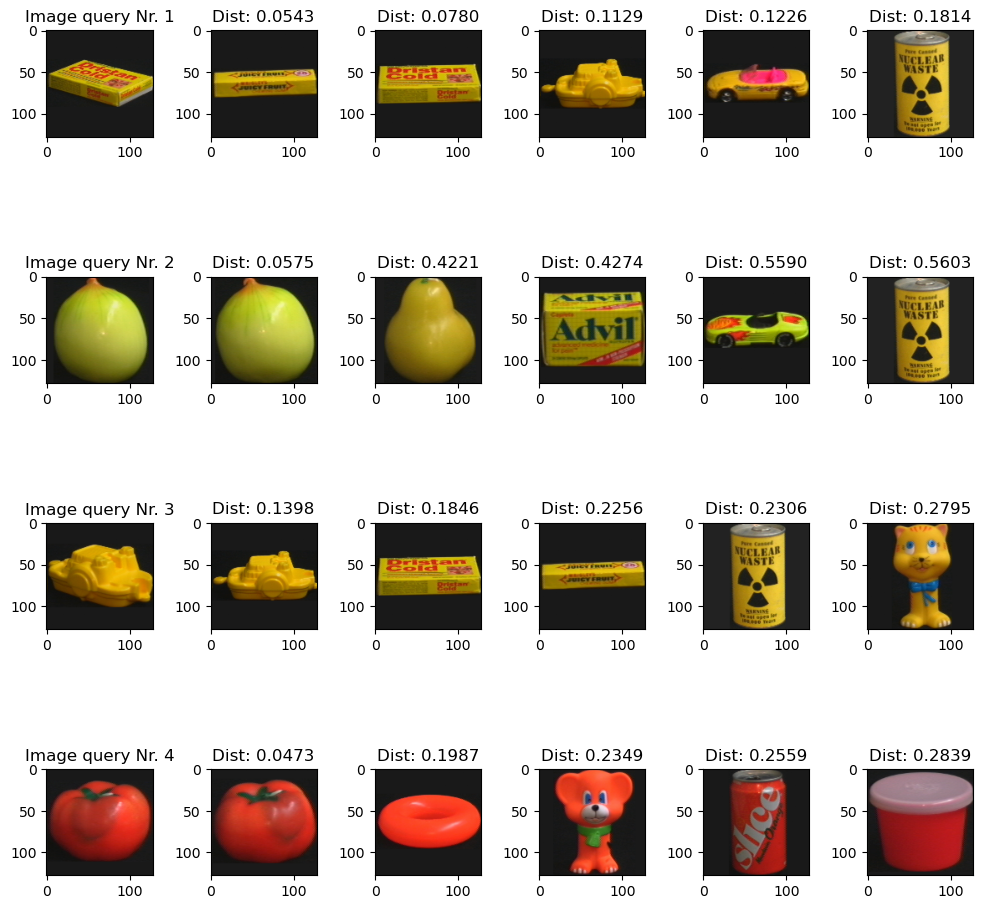

In [376]:
show_neighbors(
    model_ids = range(len(files_model)),
    query_ids = range(4),
    f_hist = rg_hist,
    f_dist = dist_intersect,
    bins = 10
)

### Recognition Rate

Use function `find_best_match` to compute recognition rates for different combinations of distance and histogram functions. The recognition rate is given by a ratio between number of correct matches and total number of query images. A match is correct if the best match of a given query image is the corresponding model image, hence, the same object. Example: Given 10 query images and 6 correct matches, the recognition rate is 6/10 = 0.6.

<font color='red'>**TODO:**</font> Compute recognition rates of different combinations of histogram functions, distance functions, and number of bins. Try to find a combination that works best. Why do you think the combination you found works particularly well? Discuss your results.

In [377]:
hist_types = [normalized_hist, rgb_hist, rg_hist, dxdy_hist]
dist_types = [dist_l2, dist_intersect, dist_chi2]
bins_list = [10, 20]
#bins_list = [10, 12, 14, 16, 18, 20]
model_ids = range(len(files_model))
#query_ids = range(len(files_query))
query_ids = range(10)
for i in range(len(hist_types)):
    for j in range(len(dist_types)):
        for k in range(len(bins_list)):
            
            best_match, distances = find_best_match(
                model_ids = model_ids,
                query_ids = query_ids,
                f_hist = hist_types[i],
                f_dist = dist_types[j],
                bins = bins_list[k]
            )
            
            sucess = 0
            for l in range(len(query_ids)):
                sucess += 1 if best_match[l] == query_ids[l] else 0
            recon_rate = sucess/len(query_ids)
            print(f"Reconstruction rate for {hist_types[i].__name__} and {dist_types[j].__name__} with {bins_list[k]} bins: {recon_rate}")
        print("-------------------------------------------------------------")

Reconstruction rate for normalized_hist and dist_l2 with 10 bins: 0.7
Reconstruction rate for normalized_hist and dist_l2 with 20 bins: 0.7
-------------------------------------------------------------
Reconstruction rate for normalized_hist and dist_intersect with 10 bins: 0.8
Reconstruction rate for normalized_hist and dist_intersect with 20 bins: 0.8
-------------------------------------------------------------
Reconstruction rate for normalized_hist and dist_chi2 with 10 bins: 0.9
Reconstruction rate for normalized_hist and dist_chi2 with 20 bins: 0.9
-------------------------------------------------------------
Reconstruction rate for rgb_hist and dist_l2 with 10 bins: 0.9
Reconstruction rate for rgb_hist and dist_l2 with 20 bins: 0.9
-------------------------------------------------------------
Reconstruction rate for rgb_hist and dist_intersect with 10 bins: 0.9
Reconstruction rate for rgb_hist and dist_intersect with 20 bins: 1.0
------------------------------------------------